In [ ]:
## load the packages

In [58]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import hydrant.topology.geom as gm
import hydrant.topology.river_graph as rg
import subprocess
import os


In [59]:
# set the path to MERIT-Basins

In [60]:
# input paths
mb_path = '/Users/shg096/Desktop/MERIT_Hydro/cat/'
rv_path = '/Users/shg096/Desktop/MERIT_Hydro/riv/'

# output paths
path_out = './output/'

In [61]:
# preparing the target pfaf areas for manupulation

In [62]:
pfafs = ['71', '72']

# Define the file name templates with a placeholder *
cat_file_template = 'cat_pfaf_*_MERIT_Hydro_v07_Basins_v01_bugfix1.shp'
riv_file_template = 'riv_pfaf_*_MERIT_Hydro_v07_Basins_v01_bugfix1.shp'

cat_files = []
riv_files = []

for pafaf in pfafs:
    # Replace * with the current pafaf value
    cat_files.append(cat_file_template.replace('*', pafaf))
    riv_files.append(riv_file_template.replace('*', pafaf))

# reading in data and append
cat = pd.concat([gpd.read_file(os.path.join(mb_path, f)) for f in cat_files])
riv = pd.concat([gpd.read_file(os.path.join(rv_path, f)) for f in riv_files])

cat.set_crs(epsg=4326, inplace=True, allow_override=True)
riv.set_crs(epsg=4326, inplace=True, allow_override=True)


,COMID,lengthkm,lengthdir,sinuosity,slope,uparea,order,strmDrop_t,slope_taud,NextDownID,maxup,up1,up2,up3,up4,geometry
0,71000001,7.020492,4.158236,1.688334,0.000570,391.901537,2,0.0,0.000000,71000065,2,71000095,71000213,0,0,"LINESTRING (-98.06167 60.00000, -98.06250 59.9..."
1,71000002,24.171249,15.709184,1.538670,0.000058,701.754912,2,1.4,0.000058,71000065,2,71000003,71000014,0,0,"LINESTRING (-98.06167 60.00000, -98.06083 60.0..."
2,71000003,14.760464,11.209022,1.316838,0.000770,480.760660,2,11.4,0.000770,71000002,2,71000004,71000011,0,0,"LINESTRING (-98.17250 60.13000, -98.17333 60.1..."
3,71000004,6.240078,4.631999,1.347168,0.000911,388.938962,2,5.7,0.000911,71000003,2,71000005,71000015,0,0,"LINESTRING (-98.33500 60.07000, -98.33583 60.0..."
4,71000005,4.462477,3.338111,1.336827,0.000670,328.557527,2,3.0,0.000670,71000004,2,71000006,71000012,0,0,"LINESTRING (-98.39917 60.09667, -98.40000 60.0..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59785,72059786,8.235011,6.125759,1.344325,0.008896,51.578512,1,73.3,0.008896,72057890,0,0,0,0,0,"LINESTRING (-81.56917 41.20250, -81.57000 41.2..."
59786,72059787,0.881055,0.648637,1.358317,0.000000,28.659389,1,0.0,0.000000,72058076,0,0,0,0,0,"LINESTRING (-84.77500 41.24333, -84.77417 41.2..."
59787,72059788,0.001115,0.001115,1.000000,0.000000,28.138533,1,0.0,0.000000,0,0,0,0,0,0,"LINESTRING (-72.38500 61.88750, -72.38500 61.8..."
59788,72059789,0.001111,0.001111,1.000000,10.799241,26.348979,1,0.0,0.000000,0,0,0,0,0,0,"LINESTRING (-55.38917 47.21667, -55.38917 47.2..."


<Axes: >

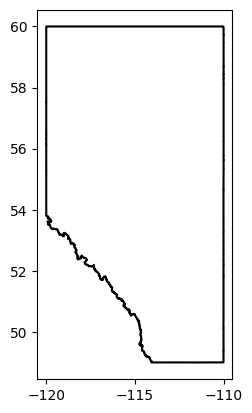

In [63]:
# Manupulate target shapefile if desired or exists (this is optional)
trg_shp = gpd.read_file('/Users/shg096/Downloads/lpr_000b16a_e/lpr_000b16a_e.shp')
sel_pr = ['Quebec', 'New Brunswick', 'Nova Scotia', 'Prince Edward Island']
sel_pr = ['Nova Scotia', 'Prince Edward Island']
sel_pr = ['Alberta']
# subsetting `provinces` variable
trg_provinces = trg_shp.loc[trg_shp.PRENAME.isin(sel_pr)].copy().to_crs(epsg=4326)
trg_provinces.boundary.plot(color='k')

In [64]:
cat, riv = gm.intersect_topology(cat=cat,\
                                 cat_cols={'id':'COMID'},\
                                 riv=riv,\
                                 riv_cols={'id':'COMID', 'next_id':'NextDownID'},\
                                 shapefile=trg_provinces)



<Axes: >

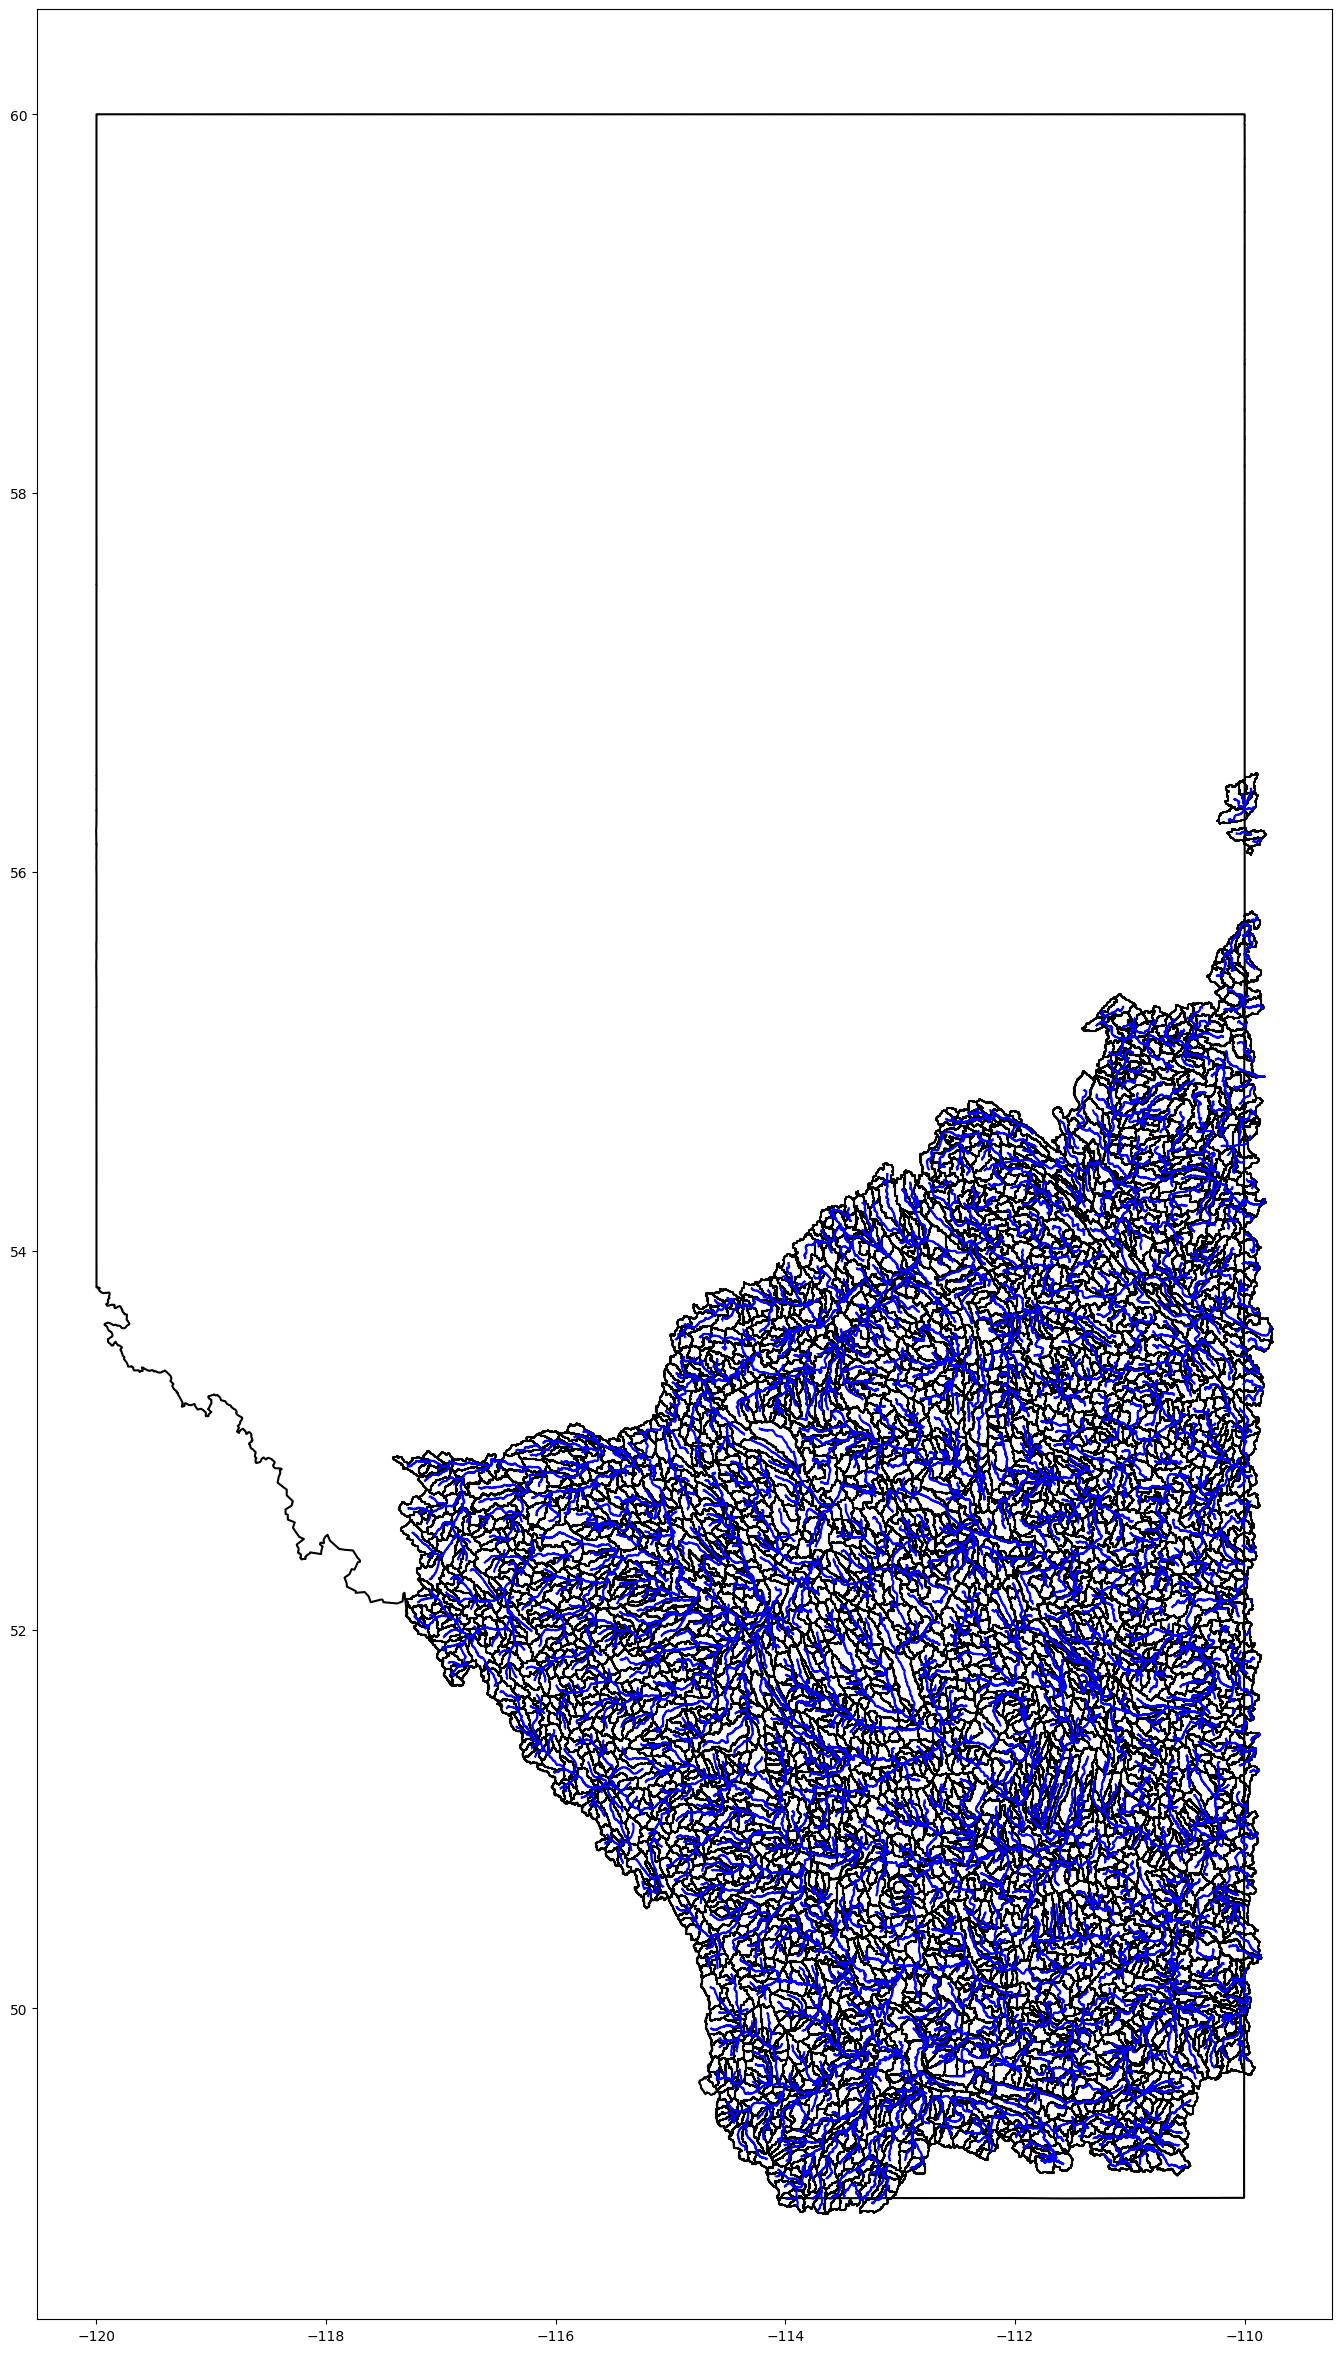

In [103]:
fig, ax = plt.subplots(figsize=(20,30))
trg_provinces.boundary.plot(ax=ax, color='k')
cat.boundary.plot(ax=ax,color='k')
riv.plot(ax=ax,color='blue')


In [81]:
def get_segment(riv,
                station_info,
                riv_col_seg,
                station_col_name = {'lat':'lat', 'lon':'lon', 'up_area':'up_area'},
                riv_col_up_area = None,
                riv_scale_up_area = None, # km2 to m2
                station_scale_up_area = None, # km2 to m2
                tolerance_for_area_diff = 0.05):

    # 
    if riv_col_up_area is not None:
        if riv_scale_up_area is not None:
            riv[riv_col_up_area] = riv[riv_col_up_area]*riv_scale_up_area

    # rename station
    station_info = station_info.rename(columns = station_col_name)
    print(station_info)

    if station_scale_up_area is not None:
        station_info.loc ['up_area'] = station_info.loc ['up_area'] * station_scale_up_area

    # 
    riv['lat_centroid'] = riv.centroid.y
    riv['lon_centroid'] = riv.centroid.x

    station_info['seg_id'] = np.NaN
    # loop over the station_info get the lat and lon and if available upstream area
    for index, row in station_info.iterrows():
        print(row)
        riv_temp = riv.copy()
        riv_temp['dist'] = 0
        riv_temp['dist'] = (riv['lat_centroid']-row['lat'])**2 + (riv['lon_centroid']-row['lon'])**2
        if (tolerance_for_area_diff is not None) and (riv_col_up_area is not None) and ('up_area' in station_col_name.keys()):
            riv_temp['area_within'] = riv_temp[riv_col_up_area].abs()/row.up_area.item()
            riv_temp = riv_temp [riv_temp ['area_within'] < tolerance_for_area_diff]
        if not riv_temp.empty: # pass Nan
            riv_temp = riv_temp.sort_values(by='dist')
            riv_temp = riv_temp.reset_index(drop=True)
            station_info['seg_id'].iloc[index] = riv_temp[riv_col_seg].iloc[0]

    return station_info
        
    

In [82]:
station_info = pd.read_csv('../../data/stations/FHM-FFAA_station_list.csv')

print(station_info)

station_info = get_segment(riv,
                station_info,
                'COMID',
                station_col_name = {'Latitude':'lat', 'Longitude':'lon'},
                riv_col_up_area = None,
                riv_scale_up_area = None, # km2 to m2
                station_scale_up_area = None, # km2 to m2
                tolerance_for_area_diff = 0.05)


  Station ID  Site type Data type (ID_type_****.csv)  \
0    05BH004  Regulated  05BH004_Annual_Flow_tab.csv   
1    05CC002  Regulated  05CC002_Annual_Flow_tab.csv   

                 Station name  Latitude  Longitude  
0        BOW RIVER AT CALGARY   51.0503   -114.051  
1  RED DEER RIVER AT RED DEER   52.2705   -113.823  
  Station ID  Site type Data type (ID_type_****.csv)  \
0    05BH004  Regulated  05BH004_Annual_Flow_tab.csv   
1    05CC002  Regulated  05CC002_Annual_Flow_tab.csv   

                 Station name      lat      lon  
0        BOW RIVER AT CALGARY  51.0503 -114.051  
1  RED DEER RIVER AT RED DEER  52.2705 -113.823  


/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_44359/1791062934.py:23: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  riv['lat_centroid'] = riv.centroid.y
/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_44359/1791062934.py:24: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  riv['lon_centroid'] = riv.centroid.x


Station ID                                          05BH004
Site type                                         Regulated
Data type (ID_type_****.csv)    05BH004_Annual_Flow_tab.csv
Station name                           BOW RIVER AT CALGARY
lat                                                 51.0503
lon                                                -114.051
seg_id                                                  NaN
Name: 0, dtype: object
Station ID                                          05CC002
Site type                                         Regulated
Data type (ID_type_****.csv)    05CC002_Annual_Flow_tab.csv
Station name                     RED DEER RIVER AT RED DEER
lat                                                 52.2705
lon                                                -113.823
seg_id                                                  NaN
Name: 1, dtype: object


/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_44359/1791062934.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  station_info['seg_id'].iloc[index] = riv_temp[riv_col_seg].iloc[0]
/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_44359/1791062934.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  station_info['seg_id'].iloc[index] = riv_temp[riv_col_seg].iloc[0]


In [83]:
print(station_info)

  Station ID  Site type Data type (ID_type_****.csv)  \
0    05BH004  Regulated  05BH004_Annual_Flow_tab.csv   
1    05CC002  Regulated  05CC002_Annual_Flow_tab.csv   

                 Station name      lat      lon      seg_id  
0        BOW RIVER AT CALGARY  51.0503 -114.051  71027770.0  
1  RED DEER RIVER AT RED DEER  52.2705 -113.823  71023173.0  


In [90]:
upstream_set = rg.find_upstream(riv,
                                71027770,
                                'COMID',
                                'NextDownID')

riv_slice = riv[riv['COMID'].isin(upstream_set)]
cat_slice = cat[cat['COMID'].isin(upstream_set)]

<Axes: >

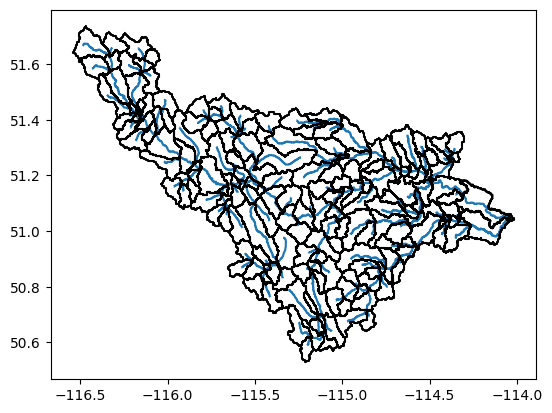

In [105]:
fig, ax = plt.subplots()
#trg_provinces.boundary.plot(ax=ax, color='k')
riv_slice.plot(ax=ax)
cat_slice.boundary.plot(ax=ax, color='k')